# SIXT33N Project
## Phase 1: PCA - Voice Commands

### EE 16B: Designing Information Devices and Systems II, Spring 2016

Written by Nathaniel Mailoa and Emily Naviasky (2016)

nmailoa@berkeley.edu &emsp; enaviasky@berkeley.edu

**Name 1**:

**Login**: ee16b-


**Name 2**:

**Login**: ee16b-

## Table of Contents

* [Introduction](#intro)
* [Part 1: Data Collection](#part1)
* [Part 2: Principal Component Analysis](#part2)
* [Part 3: Classification](#part3)
* [Part 4: Launchpad Implementation](#part4)

<a id='intro'></a>
## Introduction

In this version of the project, SIXT33N is an obedient little robot that will follow the directions that you shout at it. There are four moves that SIXT33N can make: move straight, move straight slowly, turn righ, and turn left. However, SIXT33N does not speak human languages, and some words, like "left" and "right", sound very similar while other words, like "port" and "starboard", are easy to distinguish. Your job in this phase is to find four command words that are easy for SIXT33N to tell apart.

For phase 1, you will develop the PCA classifier that allows SIXT33N to tell the difference between the four commands. You will examine several different test words, and determine which ones will be easiest to sort by PCA. However, your teammates are just starting to build the microphone circuit that will serve as SIXT33N's ears, so you will acquire sample data using the class microphone board. (You just need enough data to experiment with, you will collect your final set of training data in the next phase.)

Once you have some sample data collected, you will develop a model in this iPython Notebook (since iPython has pretty graphs and lots of computing power, and a Launchpad does not). You will perform PCA and look at how well it separates the sample data to get an idea of what words might be easily distingused. Then, once you have a set of four words that you like, you will use k-means to automatically classify them.

Once you (and your GSI) are satisfied with the classifier's accuracy, you will port the classifier into the Launchpad code in Energia. However, since your Launchpad has so much less computing power than your PC, you will examine ways to optimize the classification before you port it.  

As a reminder, you will have 2 weeks to work on this phase and choose the words and the analysis methods that work well for you before you collect your final set of training data on the microphone circuit that your teammates are building.

The goals of this phase are as follows:
- Generate envelope, threshold to get snippets
- PCA + Classifier (2-3 commands)
- Check accuracy
- PCA projection on Launchpad

As mentioned in the main project page, there is a checkpoint every week. Each checkpoint is worth 5 points, and if you are late you are awarded 4 points. The checkpoints are due in the beginning of the lab in the week after. For this phase, the checkpoints (marked **<span style="color:green">green</span>** in the Notebook) are:
- Week 1: First pass through PCA with sample data; GSI feedback
- Week 2: Classification target met in Python

<a id='part1'></a>
## <span style="color:blue">Part 1: Data Collection</span>

### Materials
- Microphone front-end circuit
- Launchpad + USB

When humans distinguish words, they listen for temporal and frequency differneces to determine what is being said. However, SIXT33N does not have the memory or the processing power to distinguish words nearly as well as our human brains, so we will have to choose much simpler features for SIXT33N to look at.

When you think of speech signals, you might notice that the shape of the speech wave is a very distinctive part of each word. Taking just the shape of the magnitude of a signal is called enveloping, exemplified in the image below. So, we want to do some filtering to retrieve the envelope of the audio signal. We can then train the PCA off of just this envelope and build a classifier to classify new data points.

<center>
<img width="500px" src="http://inst.eecs.berkeley.edu/~ee16b/fa15/lab_pics/proj-envelope.png">
</center>

Keeping in mind that the words that look most different have different shapes (or different amplitudes varied over time), brainstorm four or five words that you think will sort well.

**<span style="color:red">What words are you going to try? Why?</span>** 

Firstly, upload the sketch <b>`collect-data-envelope.ino`</b> to your Launchpad. This sketch gathers ADC samples every 0.35ms, and streams the data back to the PC. This code also sets some pins to input pins, which is required for the microphone board to work.

Attach the class microphone board to your Launchpad, as shown below. Make sure that you are connecting row 1 on the mic board to 3.3V/5V on the Launchpad. Next, you will want to remove the jumper on your Launchpad labeled 5V. You are doing this so that you can power the mic-board's 5V power off of your bench power supply. The power supply is a quieter power source than USB. <b>Put the jumper so that it is connected only to the pin closest to the usb, so that you do not lose it. We do not have replacements for them.</b> Make sure that your power supply is delivering a 100mA current limited 5V, and connect 5V to the bottom pin labeled 5V and ground to the ground pin in the opposite bottom corner. Make sure everything is hooked up as below.

<center>
<img width="600px" src="http://inst.eecs.berkeley.edu/~ee16b/sp16/lab_pics/proj-micboard.png">
</center>

Probe the test point of the board using your oscilloscope. You should see a changing signal centered around 1.5V. If the signal is centered too far from 1.5V, take a screw driver and turn the potentiometer on the microphone board until the signal is in the right place again. Make a noise at the microphone; you should see the signal change to reflect the sound you just made. If you are close enough or loud enough, you should be able to get the peak-to-peak amplitude of your signal all the way up to 3V.

<center>
<img width="400px" src="http://inst.eecs.berkeley.edu/~ee16b/sp16/lab_pics/proj-waveform.png">
</center>

Say one of the words you have chosen into the microphone and look at the scope as you say it. Try saying it softly then try shouting it. Notice how the signal gets distorted when the sound is too loud? Good audio data is loud enough that noises from the rest of the room don't show up too much, but quiet enough that the signal doesn't get distorted when it saturates the output. Position your self and monitor how loud you are speaking so that the voice samples you want to collect are loud but not distorted.

You should already have <b>`collect-data-envelope.ino`</b> uploaded to your Launchpad. This sketch will turn on the red Launchpad LED to show that it is recording. The Launchpad will record 2 seconds of audio at a time, sampled every 0.35ms. <b>The red LED on the launch pad is like a recording room. When the red light goes on the Launchpad is recording. Say the word you want to record before the red LED turns off.</b> To make your life easier, pronounce the words consistently. Try four or five words that you think will classify well. The Launchpad will apply an enveloping function (discussed later) which reduces the data from several thousand samples to 172 samples. 

Now, you have a voice sample in the Launchpad but it is deleted as soon as the light flashes again. How do you get the data out and onto the PC where you can use it? Make sure the Launchpad is connected to a USB. Then, to transfer the data in the PC, run:

<b>`python collect-data-envelope.py log.csv`</b>

Now, each time the light flashes and a sample is collected by the Launchpad, it will be written into to `log.csv`. You might want to probe the output and watch the scope while you collect. After you collect, a few test words, check the `log.csv` and make sure that it looks like an sound wave and is not just full of zeros. It might help to plot the data to make sure.


Collect around 15 good samples for each of your four to five words, and be sure to save them to different .csv files with descriptive names. You will collect more once you settle on the four words that sort well enough and once your partners are finished building the mic circuit that you will use. It is important that your final data is collected on your final mic circuit or else PCA will not work as well.

#### For your Consideration:

Once you have your four or more words collected, you can move onto the PCA classification below. You may realize in the next section that one or two of your words are not sorting quite as well as you would like. Don't be afraid to come back to this section and try collecting different words based on what you have learned makes a word sortable. 

<a id='part2'></a>
## <span style="color:blue">Part 2: Principal Component Analysis</span>

Before we can use the recorded data for PCA, we must first process the data. It is not necessary for you to understand the enveloping function well enough to implement it (since we have already done it for you), but just in case you are curious the enveloping function is described in the following pseudocode:

<code><b>Enveloping function</b>
Divide the whole signal to a block of 16 samples
For each chunk:
    Find the mean of the chunk
    Subtract each sample by the mean
    Find the sum of the absolute value of each sample
</code>

What you really need to know, however, is what the enveloped signal looks like for each word. Spend a little time looking at the data you just collected in the python plots below.

First, load the recorded data from the csv files.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.io
import scipy.cluster
from scipy import interpolate
import csv
%matplotlib inline

In [5]:
def read_csv(filename):
    data = []
    with open(filename, 'r') as csvfile:
        r = csv.reader(csvfile, delimiter=' ')
        for row in r:
            data.append([float(i) for i in row[0].split(',')])
    return np.array(data)

In [6]:
# Load data from csv
# YOUR CODE HERE
word1 = read_csv("/Users/peijiesim/Downloads/ee16bproj/week1-PCA-speech 2/collect-data-envelope/log_giddyupcircuit.csv")
word2 = read_csv("/Users/peijiesim/Downloads/ee16bproj/week1-PCA-speech 2/collect-data-envelope/log_takeiteasycircuit.csv")
word3 = read_csv("/Users/peijiesim/Downloads/ee16bproj/week1-PCA-speech 2/collect-data-envelope/log_portcircuit.csv")
word4 = read_csv("/Users/peijiesim/Downloads/ee16bproj/week1-PCA-speech 2/collect-data-envelope/log_starboardcircuit.csv")

# Take the same number of readings for all words to be fair
num_samples = min(np.shape(word1)[0], np.shape(word2)[0], np.shape(word3)[0], np.shape(word4)[0])
print(num_samples)

word1[:,:20] = np.zeros(20)
word2[:,:20] = np.zeros(20)
word3[:,:20] = np.zeros(20)
word4[:,:20] = np.zeros(20)

word1 = word1[:num_samples,:]
word2 = word2[:num_samples,:]
word3 = word3[:num_samples,:]
word4 = word4[:num_samples,:]

15


Plot your data and get a feel for how it looks enveloped.

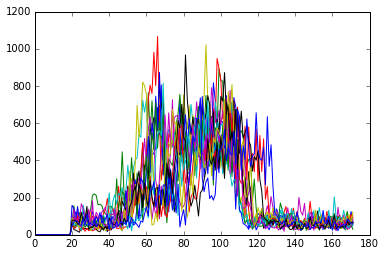

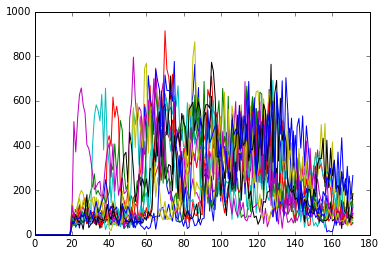

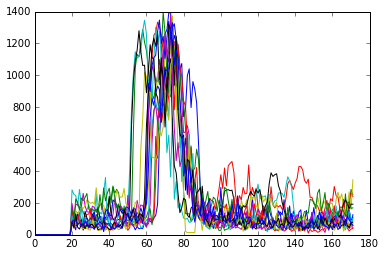

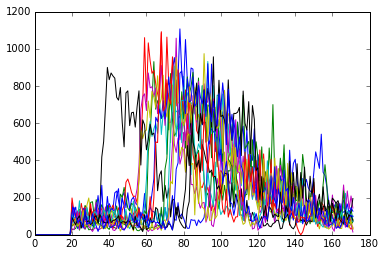

In [7]:
# Plot all word1 samples
plt.plot(word1.T)
plt.show()
plt.plot(word2.T)
plt.show()
plt.plot(word3.T)
plt.show()
plt.plot(word4.T)
plt.show()

# for i in range(num_samples):
#     plt.plot(word4[i].T)
#     plt.show()

# plt.plot(word1[14].T)
# plt.show()

# plt.plot(word3[0].T)
# plt.show()

# plt.plot(word3[14].T)
# plt.show()

# plt.plot(word4[0].T)
# plt.show()

# plt.plot(word4[14].T)
# plt.show()

As you can see above, the speech is only a small part of the 2 second window, and each sample starts at different times. PCA is not good at interpreting delay, so we need to somehow start in the same place each time and capture a smaller segment of the 2 second sample where the speech is present. To do this, we will use a thresholding algorithm just like the one used in the BMI labs. First, we define a threshold relative to the maximum value of the data. We say that any signal that crosses the threshold is the start of a speech command. In order to not lose the first couple samples of the speech command, we say that the command starts `pre_length` samples before the threshold is crossed. We then take a window of the data that is `length` long, and try to capture the entire sound of the command in that window.

Play around with the parameters `length`, `pre_length` and `threshold` in the cells below to find appropriate values corresponding to your voice and chosen commands. You should see the results and how much of your command you captured in the plots generated below. When you are satisfied, note down the values of `length`, `pre_length` and `threshold` - <b>you will need to add them to the Launchpad sketch later.</b>

In [8]:
def get_snippets(data, length, pre_length, thres):
    data_out = np.zeros((np.shape(data)[0], length))
    
    for rnum, row in enumerate(data):
        # Find the threshold
        row_thres = thres*np.max(row)

        # Figure out when interesting snippet starts
        block = pre_length
        while (row[block] < row_thres):
            block = block + 1
        block = min(block, 172 - length)
        data_out[rnum,:] = row[block-pre_length:block-pre_length+length]
        
        # Normalization
        data_out[rnum,:] = data_out[rnum,:] / np.sum(data_out[rnum,:])
        
    return data_out

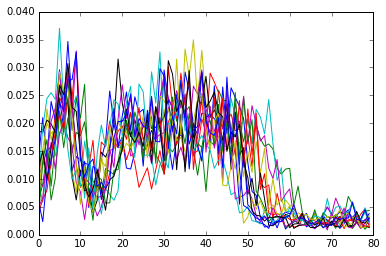

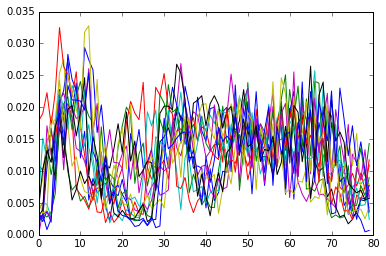

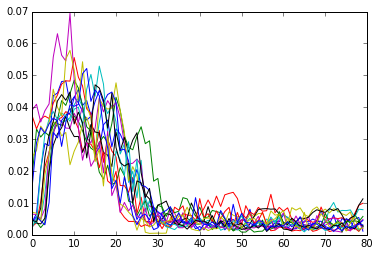

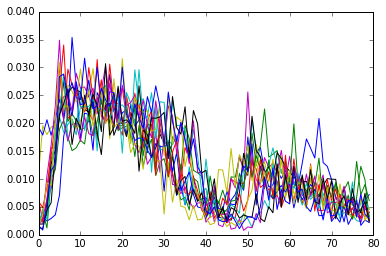

In [9]:
length = 80    # Adjust this
pre_length = 5    # Adjust this
threshold = .7   # Adjust this

word1_snippets = get_snippets(word1, length, pre_length, threshold)
plt.plot(word1_snippets.T)
plt.show()
plt.figure()
word2_snippets = get_snippets(word2, length, pre_length, threshold)
plt.plot(word2_snippets.T)
plt.show()
word3_snippets = get_snippets(word3, length, pre_length, threshold)
plt.plot(word3_snippets.T)
plt.show()
plt.figure()
word4_snippets = get_snippets(word4, length, pre_length, threshold)
plt.plot(word4_snippets.T)
plt.show()

You should now see a mostly organized set of samples for each word. Can you tell the which word is which just by the envelope? Can you tell them apart? If you can't tell the words apart, then PCA will have a difficult time as well.

Now that we have our data in a nice format, we can build the PCA input matrix from that data. The function `np.vstack` might be helpful here.


In [10]:
# YOUR CODE HERE #
A = np.vstack((word1_snippets, word2_snippets, word3_snippets, word4_snippets))

Try running the following SVD code on your matrix A, plot the sigma values and do a projection to get a base line of how well it works.

Once you get an idea of how well your data sorts on its own, you might want to experiment with using other types of pre-processing on your matrix A. For example, zero-meaning might have interesting results. Let processed_A be A with some signal processing applied to it.


**<span style="color:red">What processing techniques did you try on the matrix and and what was the result?</span>** 

In [11]:
# Zero-mean the matrix A. Note down the mean for the Launchpad code
# YOUR CODE HERE #
processed_A = A - np.mean(A)

In [12]:
# Take the SVD of matrix A
# YOUR CODE HERE #
[u,s,v] = np.linalg.svd(processed_A)

(-1, 10)

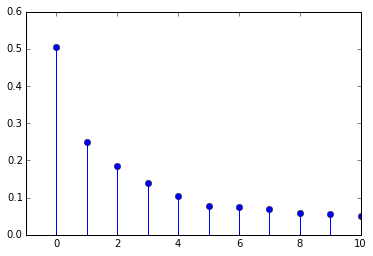

In [13]:
# Plot out the sigma values
plt.stem(s)
plt.xlim([-1,10])

Take a look at your sigma values. They should show you very clearly how many principal components you need.

**<span style="color:red">How many principal components do you need? Given that you are storting 4 words, is the the number you expected to need?</span>** 

YOUR ANSWER HERE

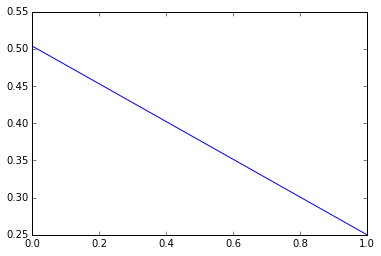

In [14]:
# Plot the principal component(s)
# YOUR CODE HERE #
plt.plot(s[:2])

Now project the data in the matrix A onto the new basis and plot it. Do you see clustering? Do you think you can separate the data easily? If not, you might need to try new words.

/Users/peijiesim/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


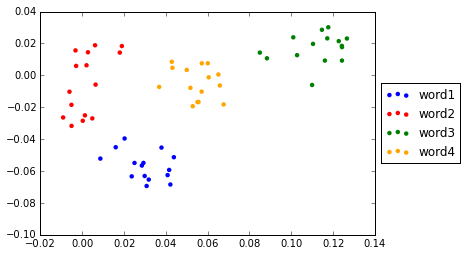

In [15]:
# Project the data onto the new basis
# YOUR CODE HERE #
proj = np.dot(processed_A, v[0:2,:].T)

plt.scatter(proj[0:num_samples,0], proj[0:num_samples,1], c=['blue'], edgecolor='none')
plt.scatter(proj[num_samples:num_samples*2,0], proj[num_samples:num_samples*2,1], c=['red'], edgecolor='none')
plt.scatter(proj[num_samples*2:num_samples*3,0], proj[num_samples*2:num_samples*3,1], c=['green'], edgecolor='none')
plt.scatter(proj[num_samples*3:num_samples*4,0], proj[num_samples*3:num_samples*4,1], c=['orange'], edgecolor='none')
plt.legend(['word1', 'word2', 'word3', 'word4'],loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

<img width='30px' align='left' src="http://inst.eecs.berkeley.edu/~ee16b/sp16/lab_pics/check.png">
<br/>
## <span style="color:green">CHECKPOINT 1</span>
 <span style="color:green">**First pass through PCA with sample data.** Show your GSI the result of the projection and talk about how you might be able to improve the result.</span>

Your data might look noisy, and might not classify perfectly. That is completely okay, we are just looking for good enough. Like many AI applications, this is noisy data that we are classifying so some error in classification is okay. The important part is if you think that you can see some clustering. 

Once you think you have decent clustering, you can move on to getting your code to automate classification and you will make up for some of the error there, too.

<a id='part3'></a>
## <span style="color:blue">Part 3:  K-Means Classification</span>

Using the plot above, we will define a way of classifying the different words. Fill in the skeleton code below to classify a vector in your new basis. 

Use a few of speech samples you collected at the beginning and test your classification on them. <b>Don't forget to do the same processing on these samples that you trained with</b> (i.e. do zero-mean by subtracting the mean of the original matrix A).

You will use k-means to classify, just as you did in the BMI lab. If you need a refresher, you can check the python documentation for the function scipy.cluster.vq.kmeans <a href="http://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.vq.kmeans.html#scipy.cluster.vq.kmeans">here</a>.

You need to be a little careful when creating the classifying algorithm since we do not want SIXT33N to pick up random sounds and treat them as one of the commands. To do this, pick a reasonably tight boundary for your classification.


In [16]:
def find_centroids(clustered_data, num_of_clusters):
    """ Use scipy.cluster.vq.kmeans to determine centroids of clusters
    Parameters:
        clustered_data: the data already projected onto the new basis
        num_of_clusters: the expected number of clusters in the data
    Returns: 
        The centroids of the clusters
    Note: You do NOT need to call the whiten function
    """
    return(scipy.cluster.vq.kmeans(clustered_data, num_of_clusters)[0])

[[ 0.03006524 -0.05675844]
 [ 0.1123092   0.0171081 ]
 [ 0.00200581 -0.00527877]
 [ 0.05480184 -0.00476585]]
The first centroid is at: [ 0.03006524 -0.05675844]
The second centroid is at: [ 0.1123092  0.0171081]
The third centroid is at: [ 0.00200581 -0.00527877]
The fourth centroid is at: [ 0.05480184 -0.00476585]


/Users/peijiesim/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


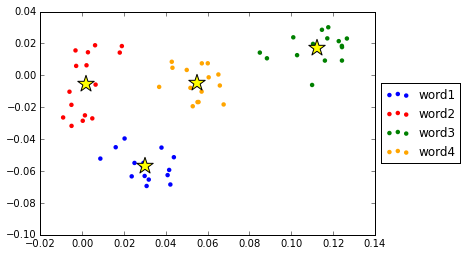

In [32]:
# Determine the centroids in the 2-neuron data

# YOUR CODE HERE #
centroid_list = find_centroids(proj, 4)
print(centroid_list)

# Print the centroid locations
centroid1 = centroid_list[0]
centroid2 = centroid_list[1]
centroid3 = centroid_list[2]
centroid4 = centroid_list[3]

print('The first centroid is at: ' + str(centroid1))
print('The second centroid is at: ' + str(centroid2))
print('The third centroid is at: ' + str(centroid3))
print('The fourth centroid is at: ' + str(centroid4))



plt.scatter(proj[0:num_samples,0], proj[0:num_samples,1], c=['blue'], edgecolor='none')
plt.scatter(proj[num_samples:num_samples*2,0], proj[num_samples:num_samples*2,1], c=['red'], edgecolor='none')
plt.scatter(proj[num_samples*2:num_samples*3,0], proj[num_samples*2:num_samples*3,1], c=['green'], edgecolor='none')
plt.scatter(proj[num_samples*3:num_samples*4,0], proj[num_samples*3:num_samples*4,1], c=['orange'], edgecolor='none')

plt.scatter(centroid_list[:,0], centroid_list[:,1], c=['yellow'], marker='*', s=300)
plt.legend(['word1', 'word2', 'word3', 'word4'],loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [33]:
def classify(data_point):
    """
    Classifies a new reading vector into a word.
    Inputs:
        data_point: new data point vector (before projection)
    Output:
        Word number
    """
    # YOUR CODE HERE
    data_point = np.dot(data_point, v[0:2,:].T)
    return (np.argmin([np.linalg.norm(data_point - cent) for cent in centroid_list]))

In [34]:
# Try out the classification function
print(classify(processed_A[0,:])) # Modify to use other vectors

0


Next, you will check the accuracy of your classification. <b>Our target is for the classifier to classify at least 80% correctly on all four words.</b> Write code to apply the `classify` function to each sample and check whether the classification is accurate. Compute the accuracy of classifying each word correctly. 

In [40]:
# Try to classify the whole A matrix
word1_good = sum([classify(processed_A[i]) == 0 for i in range(0,15)])
word1_bad = 15 - word1_good
word2_good = sum([classify(processed_A[i]) == 2 for i in range(15,30)])
word2_bad = 15 - word2_good   
word3_good = sum([classify(processed_A[i]) == 1 for i in range(30,45)])
word3_bad = 15 - word3_good
word4_good = sum([classify(processed_A[i]) == 3 for i in range(45,60)])
word4_bad = 15 - word4_good
    
print("Percent Correct of Word 1 = ", word1_good/15.0)
print("Percent Correct of Word 2 = ", word2_good/15.0)
print("Percent Correct of Word 3 = ", word3_good/15.0)
print("Percent Correct of Word 4 = ", word4_good/15.0)

Percent Correct of Word 1 =  1.0
Percent Correct of Word 2 =  1.0
Percent Correct of Word 3 =  1.0
Percent Correct of Word 4 =  1.0


#### <img width='30px' align='left' src="http://inst.eecs.berkeley.edu/~ee16b/sp16/lab_pics/check.png">
<br/>
## <span style="color:green">CHECKPOINT 2</span>
 <span style="color:green">**Show your GSI the plot of data with centroids and that you can classify the words with 80% accuracy.**</span>

<a id='part4'></a>
## <span style="color:blue">Head Start: Launchpad Implementation</span>

### Materials
- Microphone front-end circuit
- Launchpad + USB

In the next phase you will collect your true data set on your teammate's microphone circuit, and then implement your <b>data processing</b> and <b>classification</b> on the Launchpad.

If you finish this phase within the first two weeks, then we strongly recommmend you get ahead by working on "Part 3:Launchpad Implementation" in `SIXT33N-processing-speech.ipynb` to get a jump start on the processing integration phase. That section will walk you through taking the signal procesing that you just developed above and translating it from python to C that will go on your launchpad.

In addition, you will need to transfer the PCA vector and mean you found here into the launchpad. To do so, simply run the block below and copy each output into the Launchpad code.

You may also use this code for any other vectors that you need in your code.

In [122]:
a = ''
for i in v[0,:].T:
    a += str(i) + ', '
print("PC1")
print(a)
print(" ")


PC1
-0.0656834221575, -0.0771860867983, -0.0555575698972, 0.0109590458474, 0.110141140577, 0.25826099513, 0.260185432121, 0.247940054346, 0.2494635655, 0.243015869188, 0.205603525873, 0.198797687489, 0.201810503362, 0.19927849301, 0.205352681745, 0.15829223738, 0.167216952753, 0.179246598314, 0.159647723227, 0.131389721267, 0.115338246057, 0.0966359224279, 0.0791686104777, 0.0863330267714, 0.0754800087011, 0.0362966330795, 0.0298311442724, -9.50656719534e-05, 0.00327513649492, -0.0108658997396, -0.00890737756699, -0.00852697127481, -0.0119914258563, -0.0113604845626, -0.0216953462878, -0.029382203068, -0.031617588891, -0.0413795077096, -0.0459031938498, -0.0509439699129, -0.05127918702, -0.0539372658, -0.0656296896933, -0.0662808504161, -0.0626230847002, -0.0714083154648, -0.0626484969409, -0.0681490829215, -0.0680660601316, -0.0664351612868, -0.0661252824075, -0.0731204692766, -0.0702671870753, -0.0716783326674, -0.0679073407404, -0.0707749599664, -0.0670023120871, -0.0732572451915, -

In [123]:
a = np.array([[1,2,3,4,5], [6,7,8,9,10]])
for row in a:
    row = row - np.mean(row)
    print(row)

[-2. -1.  0.  1.  2.]
[-2. -1.  0.  1.  2.]
